# [train] Baseline ConvNet v2

Un premier réseau convolutionnel dédié à la classification d'imagettes extraites d'images satellites. Entrainement sur un jeu généré à partir des imagettes du défi de l'IC (véhicules et fond) et de deux sous images de la Corse. Les imagettes de tests sont générées à partir de la grille aposée sur la troisième sous image de la Corse. On commence par spécifier les paramètres généraux:

In [1]:
%cd /mnt/data/CU02_classification/

import sys
sys.path.insert(0, '/mnt/data/')
dir_train = 'data/snapshots_48x48x1/12_48x48x1_2C_PNG_BASE+CORSE+DEC+ROT+FLIP/'
dir_val = 'data/snapshots_48x48x1/03_48X48X1_2C_PNG_CORSE_TEST/'
model_shortname = 'less_filters_444'
current_notebook = 'notebooks/[train] Baseline ConvNet v2.ipynb'
logpath = 'models/hypotheses_2/'

/mnt/data/CU02_classification


## 1. Chargement des données / pré-processing

Les données d'entrainement sont des images simple bande en nuances de gris de dimensions (48,48), également appelées imagettes ou snapshots. On utilise des générateurs pour alimenter automatiquement les algorithmes à partir de dossiers, sans charger simultanément toutes les données d'entrainement en mémoire.

##### Cropping vs Downsampling : 

- On utilise la classe ImageDataGenerator de keras.preprocesssing.image légèrement adaptée pour éviter le rescaling automatique des imagettes en nuances de gris. On travaille sur les valeurs brutes des imagettes.

- Les imagettes qui font plus de (48,48) pixels sont cropées à partir du centre. On préfère cette alternative plutôt que le sous échantillonnage car on souhaite conserver tous les détails des véhicules qui sont déjà très petits. Le classe ImageDataGenerator de Keras a du là aussi eere adaptée pour découper les images plutôt qu'en réduire la résolution.

- Les véhicules n'étant pas systématiquement centré dans les imagettes, le découpage risque de supprimer certains véhicules des imagettes du jeu d'entrainement / de validation : vérifier l'impact. En terme de prédiction, le découpage des imagettes semble donner de meilleures performances que le downsampling. Les cartes de chaleurs présentent beaucoup plus de vrais positifs ET de faux positifs: on améliore le rappel mais on dégrade la précision. 

##### Autres paramètres

- Normalisation des imagettes : l'opération semble plutôt introduire de la confusion dans la réflexion, on la neutralise pour le moment. La question de fond est de savoir sur quel périmètre il faut normaliser (epoch, batch, sample).

- L'augmentation des données : idem, on neutralise jusqu'à être sur d'avoir un pipeline qui fonctionne jusqu'en prédiction.


In [2]:
from pydrm.roim.keras_image_custom2 import ImageDataGenerator

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    dir_train,
    target_size = (48,48),
    batch_size = 32,
    class_mode = 'binary',
    color_mode = 'grayscale',
    # shuffle = False
)

val_generator = val_datagen.flow_from_directory(
    dir_val,
    target_size = (48,48),
    batch_size = 32,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle = False
)

Using TensorFlow backend.


Found 119189 images belonging to 2 classes.
Found 47817 images belonging to 2 classes.



##### Classes imbalance

Le jeu de test comprend 83% d'images de fond vs 17% d'images de voitures. L'accuracy de base ne doit donc pas tomber en dessous de 83%. Pour corriger ce déséquilibre on associe un poids plus important aux imagettes de véhicules. Attention à ne pas se tromper, on associe à la classe la moins fréquente le poids le plus élevé. On améliore encore sensiblement les résultats en précision / rappel.

{0: 0.44634991484113468, 1: 0.55365008515886538}


,snapshots fond,snapshots vehicules,total,freqvoit,freqfond
traning set,65989,53200,119189,0.446350,0.553650
validation set,46307,1510,47817,0.031579,0.968421


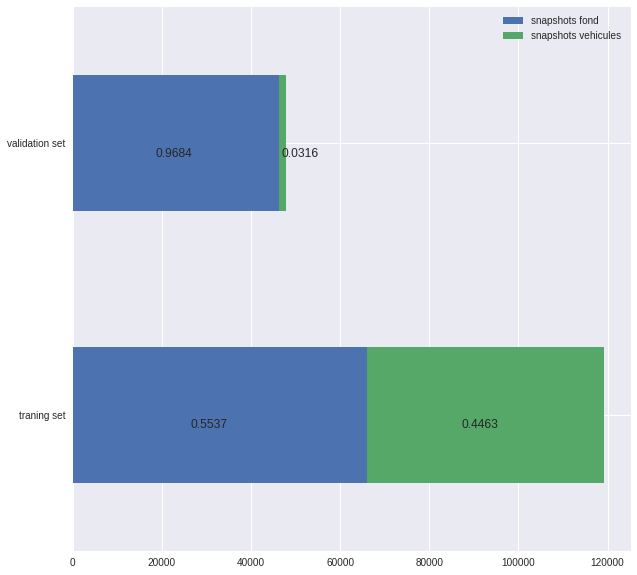

In [3]:
%matplotlib inline
import matplotlib as plt
import seaborn
import pandas as pd
import os

df = pd.DataFrame(index = ['traning set', 'validation set'])
df['snapshots fond'] = [sum(1 - train_generator.classes), sum(1- val_generator.classes)]
df['snapshots vehicules'] = [sum(train_generator.classes), sum(val_generator.classes)]
df['total'] = df['snapshots fond'] + df['snapshots vehicules']
df['freqvoit'] = df['snapshots vehicules'] / df['total']
df['freqfond'] = df['snapshots fond'] / df['total']

ax = df[['snapshots fond', 'snapshots vehicules']].plot(
    kind = 'barh', 
    stacked = True, 
    figsize = (10,10),
)

ax.title.set_fontsize(15)
ax.yaxis.label.set_fontsize(20)

vals = df[['freqfond', 'freqvoit']].T.stack().values

for p, val in zip(ax.patches, vals):
    ax.annotate(str(round(val, 4)), 
                (p.get_x() + p.get_width() * 0.4, p.get_y() + p.get_height() * 0.4),
               )

class_weight = {
    0 : sum(train_generator.classes) / train_generator.samples,
    1 : sum(1 - train_generator.classes) / train_generator.samples
}

print(class_weight)
df

## 2. Définition du ConvNet

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

def simple_image_clf() :

    model = Sequential()

    # Convolution layers

    model.add(Conv2D(filters = 4, kernel_size = (4, 4), input_shape = (48, 48, 1), strides = (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(filters = 4, kernel_size = (4, 4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(filters = 4, kernel_size = (4, 4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # The binary classifier : 2 dense layers + a sigmoid top

    model.add(Flatten())

    model.add(Dense(units = 16))
    model.add(Activation('relu'))

    model.add(Dropout(0.5))

    model.add(Dense(units = 16))
    model.add(Activation('relu'))

    model.add(Dense(units = 1))
    model.add(Activation('sigmoid'))

    return model

model = simple_image_clf()

## 3. Entrainement du modèle

#### Mesures de performance

In [5]:
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d-%H%M")
logdir = "{}/run-{}-{}/".format(logpath, now, model_shortname)
print(logdir)

from sklearn import metrics
from pydrm.callbacks import Metrics
from keras.callbacks import ModelCheckpoint

import imp
import pydrm.callbacks as cb
cb = imp.reload(cb)

checkpt_loss = ModelCheckpoint(filepath = logdir + "checkpt_loss.h5", 
                               monitor = 'loss', 
                               save_best_only = True)

checkpt_val_acc = ModelCheckpoint(filepath = logdir + "checkpt_val_acc.h5", 
                               monitor = 'val_accuracy', 
                               save_best_only = True)

metrics = {
    'val_accuracy' : metrics.accuracy_score,
    'val_precision' : metrics.precision_score,
    'val_recall' : metrics.recall_score,
    'val_f1' : metrics.f1_score,
    'val_kappa' : metrics.cohen_kappa_score
}

val_metrics = cb.Metrics(val_generator, threshold = 0.5, log_dir = logdir, metrics = metrics)
#val_metrics = cb.Metrics(dir_val, threshold = 0.5, log_dir = logdir, metrics = metrics)

models/hypotheses_2//run-20171012-1434-less_filters_444/


#### Fonction de perte et optimizer

In [6]:
from keras.optimizers import Adadelta
from keras.metrics import binary_crossentropy, binary_accuracy

model.compile(loss = binary_crossentropy,
              optimizer = Adadelta(lr = 1.0, rho = 0.95),
              metrics = [binary_accuracy])

#### Lancement du run

In [7]:
import os, shutil
if not os.path.exists(logdir):
    os.makedirs(logdir)
shutil.copy(current_notebook, logdir)
with open(logdir + 'model_architecture.json', 'w') as outfile:
    outfile.write(model.to_json())
    
steps_train = train_generator.samples // train_generator.batch_size + 1

print('Training set info : {} steps * {} images/batch, {} samples left out'.format(steps_train,
                                                                                 train_generator.batch_size,
                                                                                 train_generator.samples - (train_generator.batch_size * steps_train)))


print('Validation set info : {} steps * {} images/batch, {} samples left out'.format(val_metrics.steps,
                                                                                 val_metrics.val_generator.batch_size,
                                                                                 val_metrics.val_generator.samples - (val_metrics.val_generator.batch_size * val_metrics.steps)))

model.fit_generator(
    train_generator,
    steps_per_epoch = steps_train,
    epochs = 20,
    callbacks = [checkpt_loss, val_metrics, checkpt_val_acc],
    class_weight = class_weight
)

Training set info : 3725 steps * 32 images/batch, -11 samples left out
Validation set info : 1495 steps * 32 images/batch, -23 samples left out
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/gamma:0 is illegal; using batch_normalization_1/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
IN

3725/3725 [==============================] - 103s - loss: 0.0704 - binary_accuracy: 0.9478   
Epoch 14/20
1490/1495 [============================>.] - ETA: 0s[[40505  5802]
 [  264  1246]]
{'val_precision': 0.17678774120317819, 'loss': 0.069564097609255082, 'val_recall': 0.8251655629139073, 'binary_accuracy': 0.94803211705828228, 'val_accuracy': 0.87314135140222093, 'val_f1': 0.29118953026408034, 'val_kappa': 0.25229878012468565}
3725/3725 [==============================] - 104s - loss: 0.0696 - binary_accuracy: 0.9480   
Epoch 15/20
1490/1495 [============================>.] - ETA: 0s[[28051 18256]
 [   55  1455]]
{'val_precision': 0.073816650601187153, 'loss': 0.069431126183717537, 'val_recall': 0.96357615894039739, 'binary_accuracy': 0.94902214130548623, 'val_accuracy': 0.61706087793044317, 'val_f1': 0.13712831629046698, 'val_kappa': 0.08335476546664633}
3725/3725 [==============================] - 103s - loss: 0.0694 - binary_accuracy: 0.9490   
Epoch 16/20
1491/1495 [=============